In [2]:
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
import corner
import pandas as pd
import matplotlib.cm as cm
import random

from copy import deepcopy

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.cosmology import FlatLambdaCDM
import statistics as stats
import scipy

import semlinlens_v2bRprior as lens
import func_get_h_eta as h_eta
import func_get_rel_CK as relCK

In [6]:
plt.rcParams.update({'font.size': 17, 'text.usetex': False})
dpi_set=400
folder = './'
root = 'mock_'
ellip = True
n_samples=13
h_true = 0.7
eta_true = 1.0

In [8]:
### GATHER DATA FROM MCMC RUNS FOR EACH LENS SYSTEM
#mode='all'#'all' or 'some'
#if mode=='all':
#    mocks=[]
#    for n in range(1,101):
#        mocks.append(str(n))
#else:
#    mocks = ['50', '76', '84', '48', '19']
    #['38', '11', '66', '74', '37'] crosses-no97 #['11', '66', '74', '37', '97'] crosses+highest h bias 
    #['50', '76', '84', '48', '19'] folds+lowest h bias

combine_dat = []
combine_txt = []
combine_best = []
h_prob = []
eta_prob = []
index = 0

for n in range(0,n_samples):
    combine_dat.append(folder+root+str(n+1)+'.dat')
    combine_txt.append(folder+root+str(n+1)+'.txt')
    data = np.loadtxt(combine_txt[index])
    data = np.transpose(data)
    if ellip==False:
        h_prob.append(data[6])
        eta_prob.append(data[5])
    elif ellip==True:
        h_prob.append(data[8])
        eta_prob.append(data[7])
    index+=1

# totalmag, peakmag, Rij, tau12, tau13, tau14, tau23, tau24, tau34, time_max, time_min, annulus_length = rel.get_info(combine_dat)
# h_med, h_err, eta_med, eta_err = h_eta.get_info(combine_txt, eta_tracker=1.0, increment=0.)
# eta_bias = np.abs(eta_true-np.array(eta_med))
# h_bias = np.abs(h_true-np.array(h_med))

imgpos, drarr, taumat = relCK.get_info(combine_dat)
ann14 = drarr[:,3]
ann13 = drarr[:,2]
ann12 = drarr[:,1]
tau14 = taumat[:,0,3]
tau13 = taumat[:,0,2]
tau12 = taumat[:,0,1]
annulus_length = ann12

imgpos, drarr, taumat


In [10]:
### FLAG BY ANNULUS LENGTH
n_sigma = 1

flags = []
number = 0

med = stats.median(annulus_length)
error = (stats.stdev(annulus_length))
print('median is: '+str(med))

for n in range(0,n_samples):
    if annulus_length[n] <= med:
        flags.append(False)
    else:
        flags.append(True)
        number += 1

print(number)
print(annulus_length)
print(flags)

median is: 0.2201876655822188
6
[0.18817608 0.11347822 0.59962209 0.47959999 0.04058103 0.15413013
 0.40142608 0.07421411 0.23814028 0.22018767 0.29480471 0.25643991
 0.09521704]
[False, False, True, True, False, False, True, False, True, False, True, True, False]


In [11]:
bin_num = 40
list_bins = np.linspace(0.5, 1.5, bin_num)
import matplotlib.cm as cm
plot_choice = True

#colors = cm.viridis(np.linspace(0,1,len(mocks)))

Pall = np.ones(len(list_bins))

kde_pdf = []
number = 0
for n in range(0,len(h_prob)):
    if (n % round(len(h_prob)/10)) == 0:
        print(str(n)+'/'+str(n_samples))
    kde_func = gaussian_kde(h_prob[n])
    kde_pdf.append(kde_func(list_bins))
    if flags[n] == True:
        number += 1
        Pall *= kde_pdf[n]

# normalize distribution
norm = np.sum(Pall)*(list_bins[1]-list_bins[0])
Pall /= norm

print(str(number)+' out of '+str(n_samples)+' lenses used!')

0/13
1/13
2/13
3/13
4/13
5/13
6/13
7/13
8/13
9/13
10/13
11/13
12/13
6 out of 13 lenses used!


median, lower limit, upper limit:
0.6943870288304975 0.6769898623784142 0.7158677840397762
lower error, upper error:
0.017397166452083335 0.021480755209278724


Text(0.5, 1.0, 'rel bias: 0.8%, h=$0.694^{+0.0215}_{-0.0174}$')

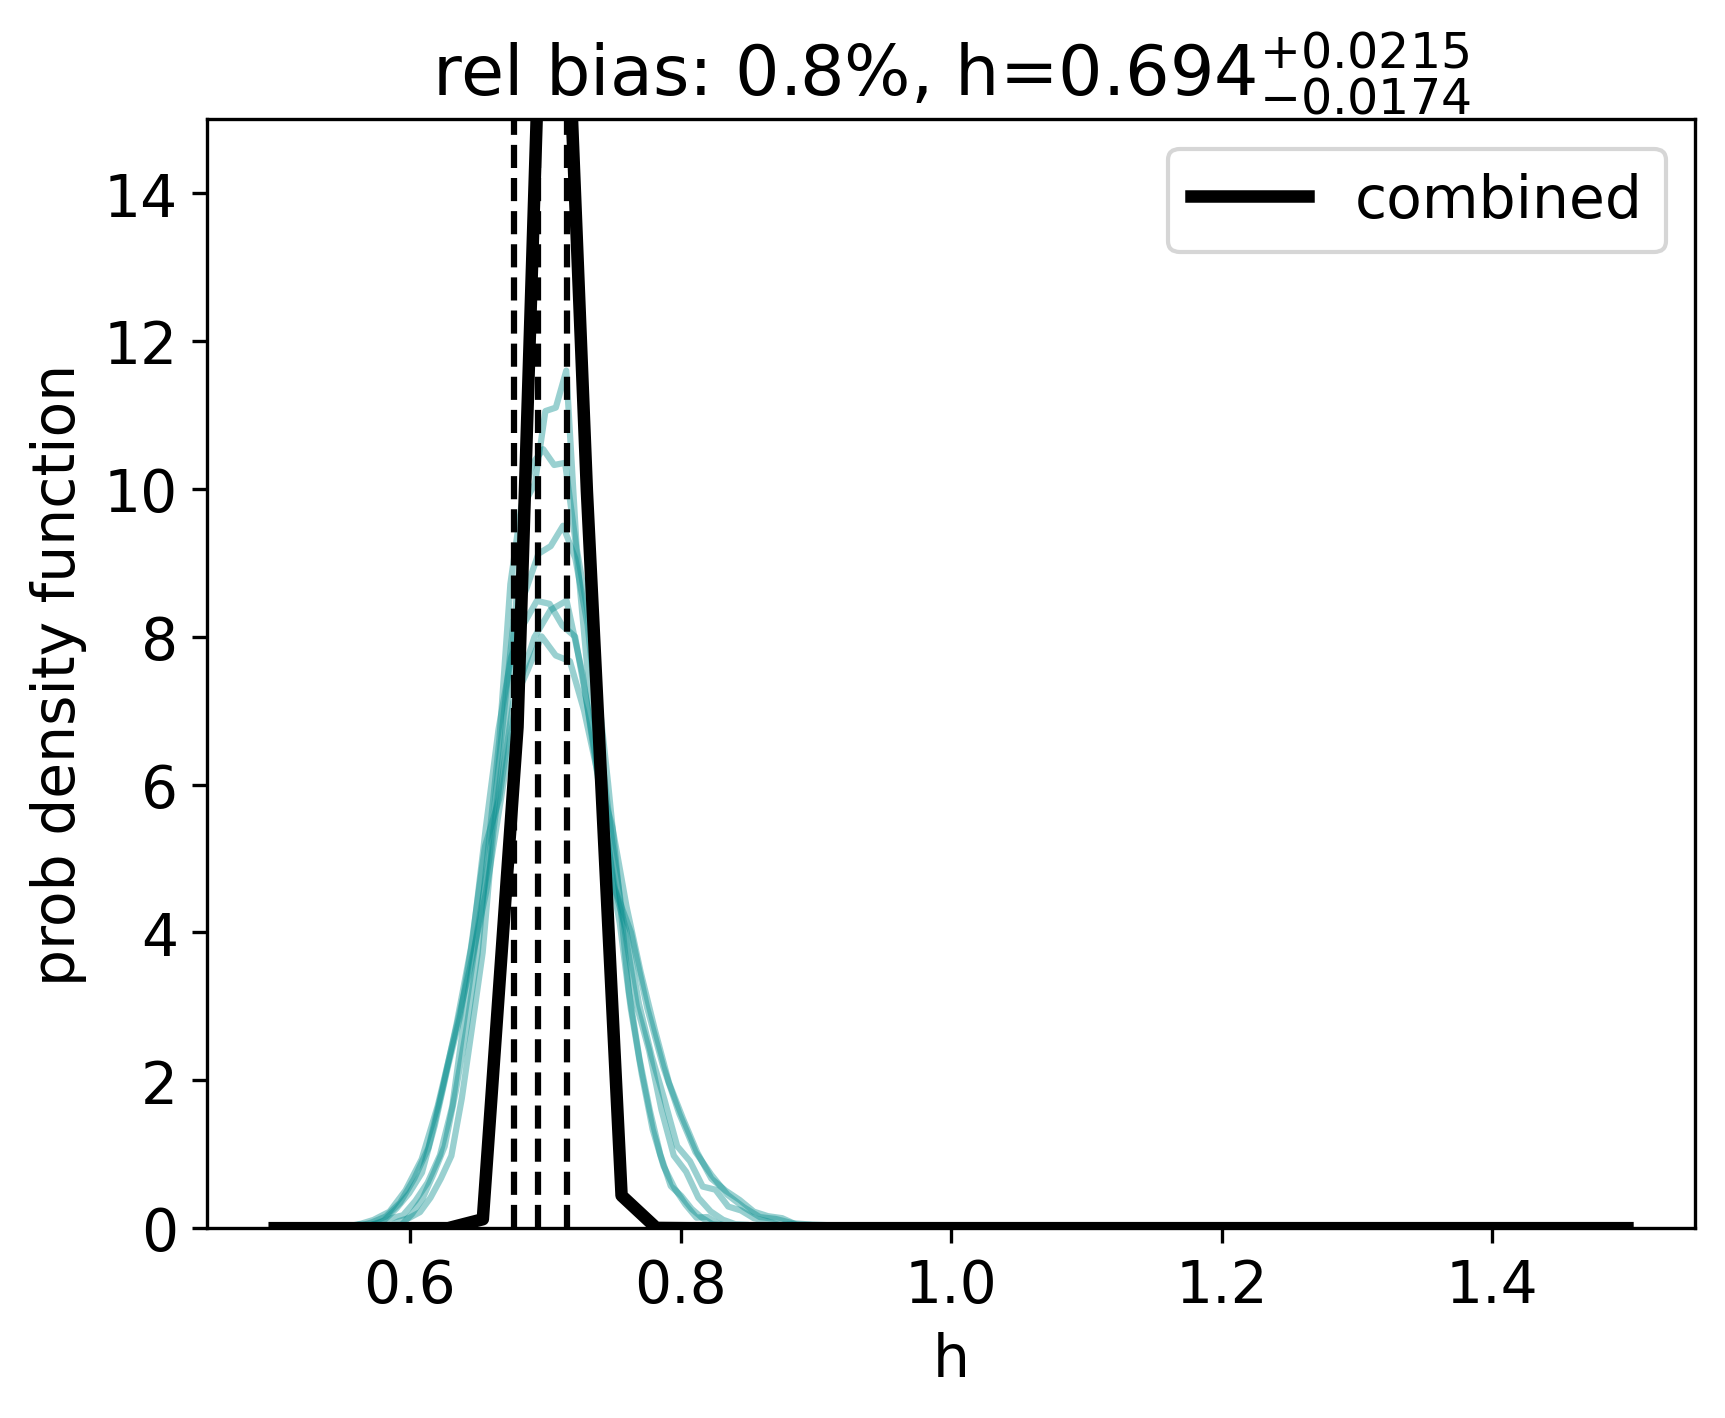

In [15]:
### PLOT COMBINED H DISTRIBUTION!

plt.rcParams.update({'font.size': 14, 'text.usetex': False})
plt.rc('axes', labelsize=14)

plt.figure(dpi=300)

color='darkcyan'
if ellip == False:
    label='circ+shear'
else:
    label='ellip+shear'

for n in range(0,len(h_prob)):    
    if flags[n] == True:
        num, bins = np.histogram(h_prob[n], bins=bin_num, density=True)
        if n==n_samples-1:
            plt.plot(bins[:-1], num, color=color, alpha=0.4, label=label)

        else:
            plt.plot(bins[:-1], num, color=color, alpha=0.4)
    
plt.plot(list_bins, Pall, color='black', label='combined', linewidth=3)
plt.legend()
plt.xlabel('h')
plt.ylabel('prob density function')

# cdf and interpolation to get the med and errors within 68% confidence interval
cdf = (np.cumsum(Pall)*(list_bins[1]-list_bins[0]))
cdf_interp = scipy.interpolate.interp1d(cdf, list_bins)
x_50 = cdf_interp(0.5)
x_16 = cdf_interp(0.16)
x_84 = cdf_interp(0.84)
lower_err = np.abs(x_50 - x_16)
upper_err = np.abs(x_50 - x_84)

bias = np.abs(h_true-x_50)
rel_bias = round((bias/h_true*100),2)

print('median, lower limit, upper limit:')
print(x_50, x_16, x_84)
print('lower error, upper error:')
print(lower_err, upper_err)

index_maxpdf = np.argsort(Pall)[-1]
length = 10
color2 = 'black'
plt.plot([x_16]*length, np.linspace(np.min(Pall), np.max(Pall)+10,10), linestyle='--', color=color2)
plt.plot([x_84]*length, np.linspace(np.min(Pall), np.max(Pall)+10,10), linestyle='--', color=color2)
plt.plot([x_50]*length, np.linspace(np.min(Pall), np.max(Pall)+10,10), linestyle='--', color=color2)
plt.ylim([0,15])
plt.title('rel bias: {}%, h=${}^{{{}}}_{{{}}}$'.format(rel_bias, str(np.round(x_50,3)), 
                                        '+'+str(np.round(upper_err,4)), '-'+str(np.round(lower_err,4))) )
